# **Final Project: Car Price Prediction and Recommendation using Machine Learning**

*   Dataset: Scraped used and new car data from TrueCars.com
*   Project Team: Team Orion: [Eric Cheng, Hung Le, Babu Rajendran, Archana Shokeen, Tingjia Zhang]

# **CRISP DM**

### Business Understanding

*   Provide potential customers with a better understanding of the value of their car, and if they are thinking of purchasing a used car, get an idea of what the purchasing price of that car should be close to.

### Data Understanding

*   Checked the shape and types of the attributes for each column
*   Visualized the relationship between the columns using correlation plots, sns scatterplots, and identifying any patterns

### Data Preparation

*  We checked for null values and removed them after scraping, removed duplicate values, removed any punctuation 
*  Through feature extraction, we got the deprecation score and the original price from the current price of the used car, which will be used as part of the training and testing set.

### Modeling

*  KMeans Clustering was used to find the golden clusters; total three KMeans iterations
*  Main Regression Model used include: Linear Regression, MLPRegressor, RandomForestRegressor, KNNRegressor, XBoost Regressor

### Evaluation

*  Each model was evaluated for its R2 score and accuracy score based on the X_train and X_test using the train_and_test_split() function. The RandomForest Regressor was then pickled from the results for deployment purposes.

### Deployment

*  Pickled RandomForestRegressor model and scores were used to deploy on a website in Heroku using Flask API that takes in user data and executes the prediction algorithm based on pickled data.

In [98]:
!pip install beautifulsoup4
!pip install requests_cache

Import the libraries used in this project.These include the scraping libraries, models, and generic libraries used for modifying dataframes and visualizations.

In [99]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import requests_cache
import lxml.html as lxl
import re

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import sklearn.metrics as metrics

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

In [102]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We can get the cleaned scraped data from the TrueCars used car listing catalogue, which we will use as the basis of our project. 

In [103]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data Mining/Final Project/listing-cleaned.csv')
df.head(10)

,Unnamed: 0,year,make,model,sub_model,city,state,mileage,price,style,exterior_color,interior_color,engine,drive_type,fuel_type,transmission,accidents,title,owners,use_type
0,0,2021,Chevrolet,Suburban,LT RWD,San Antonio,TX,8404,67994,SUV,Satin Steel Metallic,Jet Black,5.3L V-8 Gas,RWD,Gas,Automatic,0,Clean,1,Personal Use
1,1,2017,Cadillac,CTS,Premium Luxury 3.6 AWD,Phoenix,AZ,29342,37000,Sedan,Black Raven,Jet Black With Morello Red Accents,3.6L V-6 Gas,AWD,Gas,Automatic,0,Clean,1,Personal Use
2,2,2019,Kia,Forte,LXS IVT,Bensalem,PA,17593,22395,Sedan,Clear White,Black,2.0L Inline-4 Gas,FWD,Gas,Automatic,0,Clean,2,Personal Use
3,3,2018,Ford,F-150,XLT SuperCrew 5.5' Box 4WD,Hudson,WI,195205,20995,Pickup Truck,Shadow Black,Medium Earth Gray,2.7L V-6 Gas Turbocharged,4WD,Gas,Automatic,0,Clean,1,Personal Use
4,4,2018,Ford,F-150,XLT SuperCrew 5.5' Box 4WD,Pikeville,KY,47922,32988,Pickup Truck,Black,Black,3.3L V-6 Gas,4WD,Gas,Automatic,0,Clean,4,Rental Use
5,5,2019,Ford,Super Duty F-250,Lariat 4WD Crew Cab 6.75' Box,Lubbock,TX,24553,57899,Pickup Truck,White Platinum Metallic Tri-Coat,Medium Light Camel,6.2L V-8 Gas,4WD,Gas,Automatic,0,Clean,1,Personal Use
6,6,2015,Nissan,Altima,2.5 S,Lubbock,TX,119901,11785,Sedan,Super Black,Charcoal,2.5L Inline-4 Gas,FWD,Gas,Automatic,0,Clean,2,Rental Use
7,7,2015,Nissan,Altima,2.5 S,Tempe,AZ,92366,10995,Sedan,White,Black,2.5L Inline-4 Gas,FWD,Gas,Automatic,1,Clean,2,Mixed Use
8,8,2018,Toyota,RAV4,XLE FWD,Ocala,FL,33633,21977,SUV,Silver Sky Metallic,Black,2.5L Inline-4 Gas,FWD,Gas,Automatic,1,Clean,1,Personal Use
9,9,2018,Chevrolet,Silverado 1500,LT Z71 Crew Cab Short Box 4WD,Austin,TX,159889,25950,Pickup Truck,Silver Ice Metallic,Jet Black,5.3L V-8 Gas,4WD,Gas,Automatic,0,Clean,1,Personal Use


Check the types of data and its attributes.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      9900 non-null   int64 
 1   year            9900 non-null   int64 
 2   make            9900 non-null   object
 3   model           9900 non-null   object
 4   sub_model       9900 non-null   object
 5   city            9900 non-null   object
 6   state           9900 non-null   object
 7   mileage         9900 non-null   int64 
 8   price           9900 non-null   int64 
 9   style           9900 non-null   object
 10  exterior_color  9900 non-null   object
 11  interior_color  9900 non-null   object
 12  engine          9900 non-null   object
 13  drive_type      9900 non-null   object
 14  fuel_type       9900 non-null   object
 15  transmission    9900 non-null   object
 16  accidents       9900 non-null   int64 
 17  title           9900 non-null   object
 18  owners  

In [105]:
df.shape

(9900, 20)

Since we have already done the preprocessing and cleaning during the scraping phase, there should be no null values left. We use isnull().sum() to check again and make sure. SInce there are no null values, we are good to go.

In [106]:
df.isnull().sum()

Unnamed: 0        0
year              0
make              0
model             0
sub_model         0
city              0
state             0
mileage           0
price             0
style             0
exterior_color    0
interior_color    0
engine            0
drive_type        0
fuel_type         0
transmission      0
accidents         0
title             0
owners            0
use_type          0
dtype: int64

# **Data Preprocessing**

We want to do feature extraction of the data, specifically labeling out the metrics for under what conditions the vehicle should be a good buy versus when it should not be recommended to purchase. To do this, we first want to estimate the age of the car by subtracting it from the current year. Using this metric we can also calculate the depreciation value of the car using the formula A = P(1- (r/100))^n where A is the current value, P is the original price, r is the depreciation rate, and n is the number of years that have passed since the car was first sold.

In [107]:
df["current_Year"] = 2021

In [108]:
df["age"] = df["current_Year"] - df["year"]
df["original_Price"] = df["price"]/ ((1 - (0.45)) ** 3)
df["depreciation"] = df["original_Price"] - df["price"]
df["percent_Loss"] = df["price"] / df["original_Price"]
#df["Good_Buy"] = 1 if np.where(df["Percent_Loss"] < 0.6) else 0

In [109]:
df.head(10)

,Unnamed: 0,year,make,model,sub_model,city,state,mileage,price,style,exterior_color,interior_color,engine,drive_type,fuel_type,transmission,accidents,title,owners,use_type,current_Year,age,original_Price,depreciation,percent_Loss
0,0,2021,Chevrolet,Suburban,LT RWD,San Antonio,TX,8404,67994,SUV,Satin Steel Metallic,Jet Black,5.3L V-8 Gas,RWD,Gas,Automatic,0,Clean,1,Personal Use,2021,0,408679.188580,340685.188580,0.166375
1,1,2017,Cadillac,CTS,Premium Luxury 3.6 AWD,Phoenix,AZ,29342,37000,Sedan,Black Raven,Jet Black With Morello Red Accents,3.6L V-6 Gas,AWD,Gas,Automatic,0,Clean,1,Personal Use,2021,4,222389.181067,185389.181067,0.166375
2,2,2019,Kia,Forte,LXS IVT,Bensalem,PA,17593,22395,Sedan,Clear White,Black,2.0L Inline-4 Gas,FWD,Gas,Automatic,0,Clean,2,Personal Use,2021,2,134605.559730,112210.559730,0.166375
3,3,2018,Ford,F-150,XLT SuperCrew 5.5' Box 4WD,Hudson,WI,195205,20995,Pickup Truck,Shadow Black,Medium Earth Gray,2.7L V-6 Gas Turbocharged,4WD,Gas,Automatic,0,Clean,1,Personal Use,2021,3,126190.833959,105195.833959,0.166375
4,4,2018,Ford,F-150,XLT SuperCrew 5.5' Box 4WD,Pikeville,KY,47922,32988,Pickup Truck,Black,Black,3.3L V-6 Gas,4WD,Gas,Automatic,0,Clean,4,Rental Use,2021,3,198274.981217,165286.981217,0.166375
5,5,2019,Ford,Super Duty F-250,Lariat 4WD Crew Cab 6.75' Box,Lubbock,TX,24553,57899,Pickup Truck,White Platinum Metallic Tri-Coat,Medium Light Camel,6.2L V-8 Gas,4WD,Gas,Automatic,0,Clean,1,Personal Use,2021,2,348003.005259,290104.005259,0.166375
6,6,2015,Nissan,Altima,2.5 S,Lubbock,TX,119901,11785,Sedan,Super Black,Charcoal,2.5L Inline-4 Gas,FWD,Gas,Automatic,0,Clean,2,Rental Use,2021,6,70833.959429,59048.959429,0.166375
7,7,2015,Nissan,Altima,2.5 S,Tempe,AZ,92366,10995,Sedan,White,Black,2.5L Inline-4 Gas,FWD,Gas,Automatic,1,Clean,2,Mixed Use,2021,6,66085.649887,55090.649887,0.166375
8,8,2018,Toyota,RAV4,XLE FWD,Ocala,FL,33633,21977,SUV,Silver Sky Metallic,Black,2.5L Inline-4 Gas,FWD,Gas,Automatic,1,Clean,1,Personal Use,2021,3,132093.163035,110116.163035,0.166375
9,9,2018,Chevrolet,Silverado 1500,LT Z71 Crew Cab Short Box 4WD,Austin,TX,159889,25950,Pickup Truck,Silver Ice Metallic,Jet Black,5.3L V-8 Gas,4WD,Gas,Automatic,0,Clean,1,Personal Use,2021,3,155972.952667,130022.952667,0.166375


We can then filter out the features that are most likely significant and store them in our dataframe for the next step.

In [110]:
features_list = ["year", "make", "model", "city", "state", "mileage", "price", "style", "accidents", "owners", "age", "original_Price", "depreciation", "percent_Loss"]
df = df[features_list]
df.head(10)

,year,make,model,city,state,mileage,price,style,accidents,owners,age,original_Price,depreciation,percent_Loss
0,2021,Chevrolet,Suburban,San Antonio,TX,8404,67994,SUV,0,1,0,408679.188580,340685.188580,0.166375
1,2017,Cadillac,CTS,Phoenix,AZ,29342,37000,Sedan,0,1,4,222389.181067,185389.181067,0.166375
2,2019,Kia,Forte,Bensalem,PA,17593,22395,Sedan,0,2,2,134605.559730,112210.559730,0.166375
3,2018,Ford,F-150,Hudson,WI,195205,20995,Pickup Truck,0,1,3,126190.833959,105195.833959,0.166375
4,2018,Ford,F-150,Pikeville,KY,47922,32988,Pickup Truck,0,4,3,198274.981217,165286.981217,0.166375
5,2019,Ford,Super Duty F-250,Lubbock,TX,24553,57899,Pickup Truck,0,1,2,348003.005259,290104.005259,0.166375
6,2015,Nissan,Altima,Lubbock,TX,119901,11785,Sedan,0,2,6,70833.959429,59048.959429,0.166375
7,2015,Nissan,Altima,Tempe,AZ,92366,10995,Sedan,1,2,6,66085.649887,55090.649887,0.166375
8,2018,Toyota,RAV4,Ocala,FL,33633,21977,SUV,1,1,3,132093.163035,110116.163035,0.166375
9,2018,Chevrolet,Silverado 1500,Austin,TX,159889,25950,Pickup Truck,0,1,3,155972.952667,130022.952667,0.166375


In [202]:
df['style'].unique()

array(['SUV', 'Sedan', 'Pickup Truck', 'Minivan', 'Coupe', 'Hatchback',
       'Cargo Van', 'Convertible', 'Passenger Van', 'Wagon',
       'Chassis Cab Truck'], dtype=object)

# **Visualization**

Looking at this plot we can see the range and diversity of the different brands of vehicles there are, with a huge collection of Ford vehicles and a generous amount of Chevorlet vehicles.

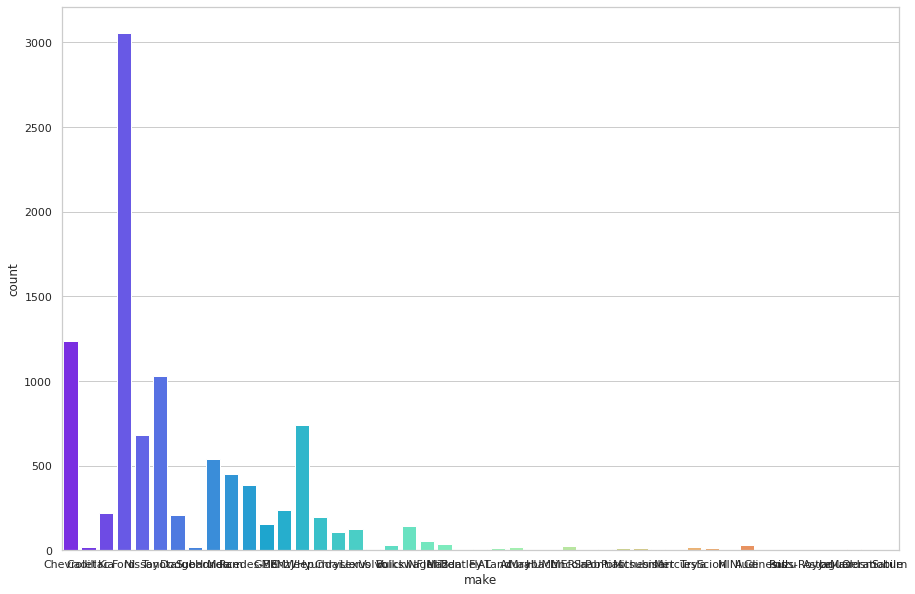

In [111]:
sns.set_style('whitegrid')
sns.countplot(x= 'make', data=df, palette='rainbow')
sns.set(rc = {'figure.figsize':(15,10)})

Using get_dummies, we can convert the categorical data in the dataset into indicator data, which can be used for visualization and training and testing purposes.

In [208]:
df_cor = pd.concat([df, pd.get_dummies(df['make'], prefix='model')],axis=1)
df_cor.head(10)

,year,make,model,city,state,mileage,price,style,accidents,owners,age,original_Price,depreciation,percent_Loss,model_Acura,model_Aston,model_Audi,model_BMW,model_Bentley,model_Buick,model_Cadillac,model_Chevrolet,model_Chrysler,model_Dodge,model_FIAT,model_Ford,model_GMC,model_Genesis,model_HUMMER,model_Honda,model_Hyundai,model_INFINITI,model_Isuzu,model_Jaguar,model_Jeep,model_Kia,model_Land,model_Lexus,model_Lincoln,model_MINI,model_Maserati,model_Maybach,model_Mazda,model_Mercedes-Benz,model_Mercury,model_Mitsubishi,model_Nissan,model_Oldsmobile,model_Pontiac,model_Porsche,model_Ram,model_Rolls-Royce,model_Saab,model_Saturn,model_Scion,model_Subaru,model_Tesla,model_Toyota,model_Volkswagen,model_Volvo,model_smart
0,2021,Chevrolet,Suburban,San Antonio,TX,8404,67994,SUV,0,1,0,408679.188580,340685.188580,0.166375,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017,Cadillac,CTS,Phoenix,AZ,29342,37000,Sedan,0,1,4,222389.181067,185389.181067,0.166375,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019,Kia,Forte,Bensalem,PA,17593,22395,Sedan,0,2,2,134605.559730,112210.559730,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,Ford,F-150,Hudson,WI,195205,20995,Pickup Truck,0,1,3,126190.833959,105195.833959,0.166375,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018,Ford,F-150,Pikeville,KY,47922,32988,Pickup Truck,0,4,3,198274.981217,165286.981217,0.166375,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2019,Ford,Super Duty F-250,Lubbock,TX,24553,57899,Pickup Truck,0,1,2,348003.005259,290104.005259,0.166375,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2015,Nissan,Altima,Lubbock,TX,119901,11785,Sedan,0,2,6,70833.959429,59048.959429,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2015,Nissan,Altima,Tempe,AZ,92366,10995,Sedan,1,2,6,66085.649887,55090.649887,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2018,Toyota,RAV4,Ocala,FL,33633,21977,SUV,1,1,3,132093.163035,110116.163035,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2018,Chevrolet,Silverado 1500,Austin,TX,159889,25950,Pickup Truck,0,1,3,155972.952667,130022.952667,0.166375,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here we can see the correlation between age and the price of the vehicle according to the make of the car. Not surprisinly, as the car gets older, the less it is worth. 

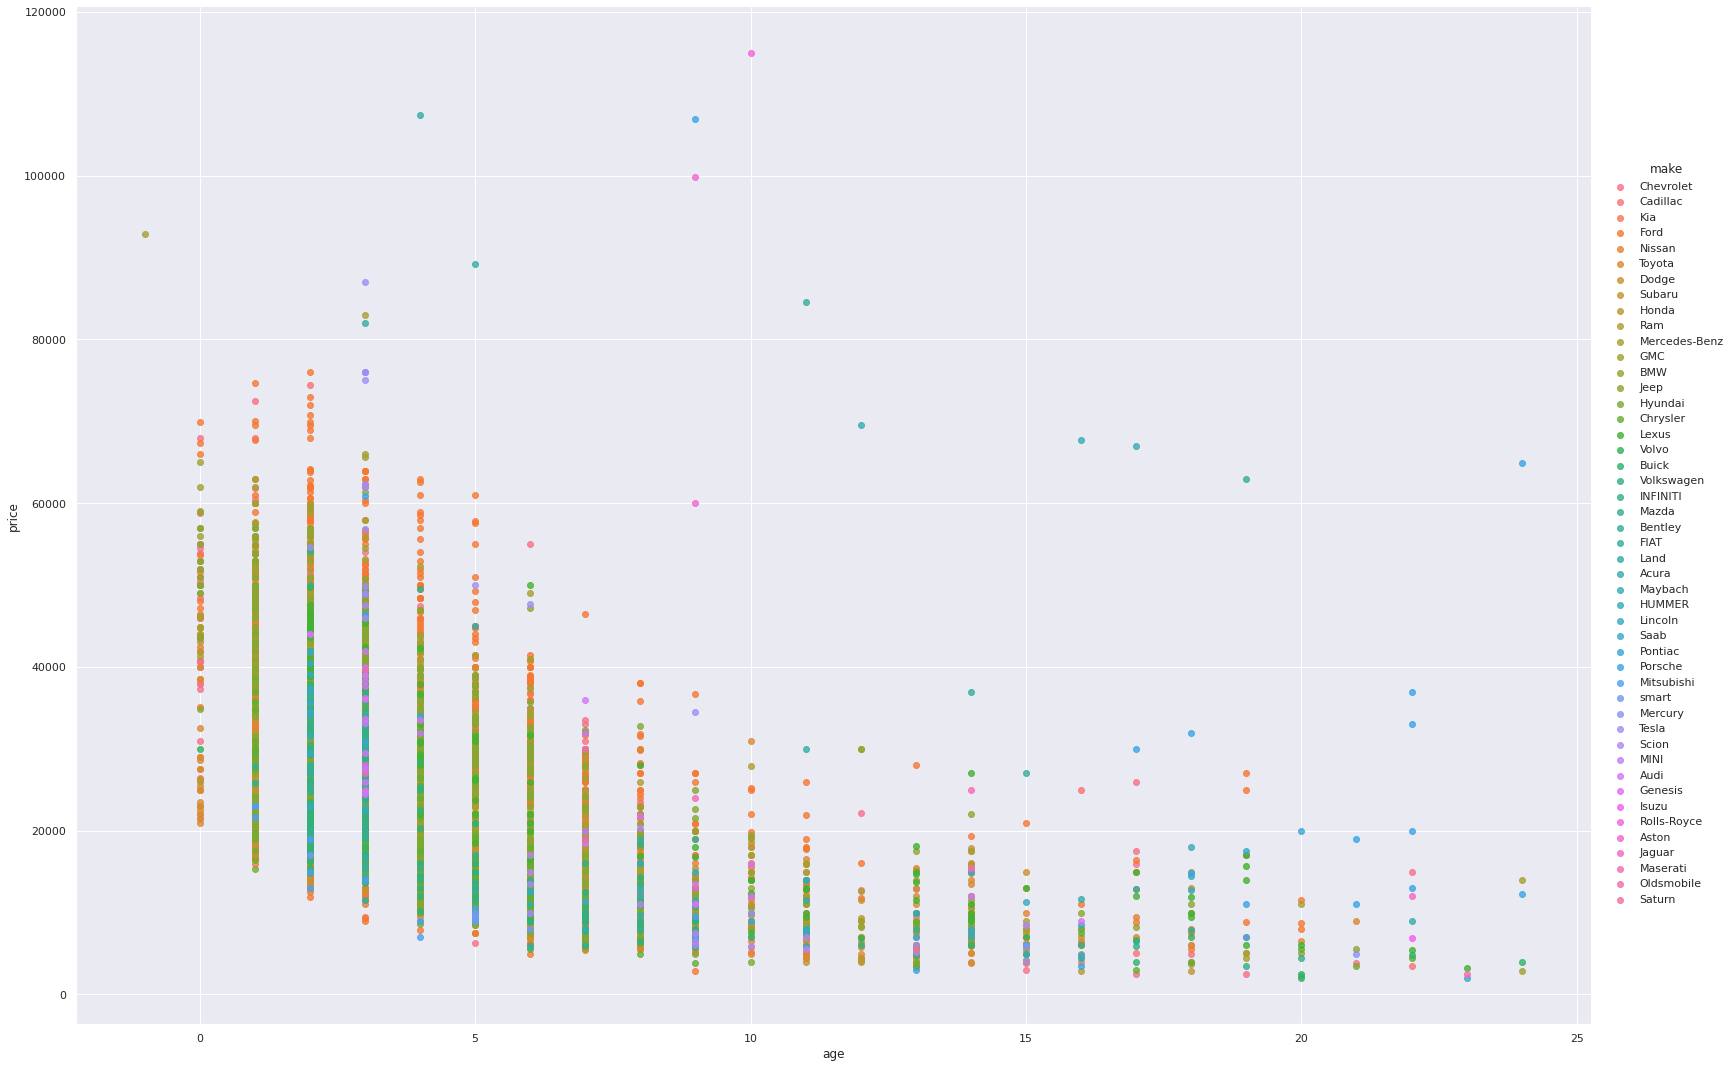

In [113]:
sns.lmplot(x='age', y='price', hue='make', data= df_cor, fit_reg= False, height=15, aspect=1.5)

The mileage chart also shows a similar trend; as the car increases in mileage, the price has a corresponding downwards trend.

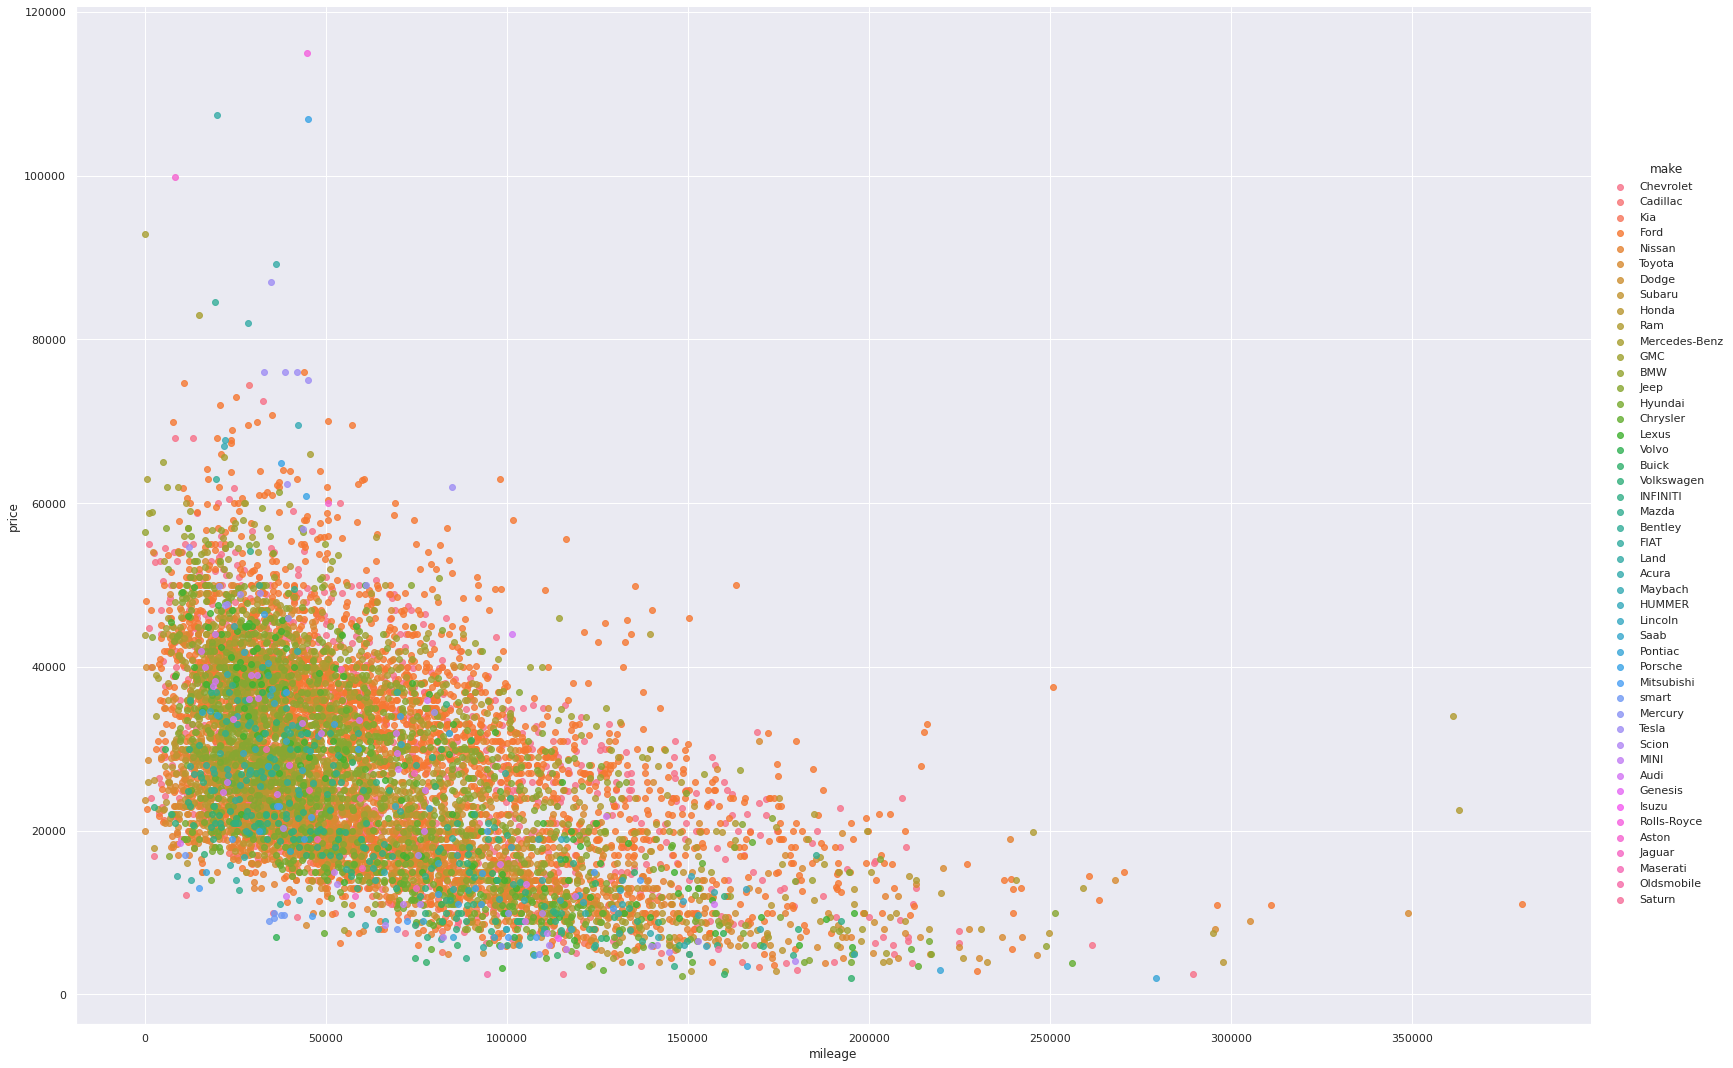

In [114]:
sns.lmplot(x='mileage', y='price', hue='make', data= df_cor, fit_reg= False, height=15, aspect=1.5)

In [115]:
final_df = pd.get_dummies(df, drop_first=True)

# **Gini Score for Feature Importance**

Next we want to see which features are most important for predicting whether or not the car is a good purchase. We use an ExtraTreesRegressor and split the training and testing data, which gives us the attributes that are most important. In this case, deprecation and original price are most important, followed by year, mileage, and age.

In [116]:
final_df.head(5)

,year,mileage,price,accidents,owners,age,original_Price,depreciation,percent_Loss,make_Aston,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_FIAT,make_Ford,make_GMC,make_Genesis,make_HUMMER,make_Honda,make_Hyundai,make_INFINITI,make_Isuzu,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Lexus,make_Lincoln,make_MINI,make_Maserati,make_Maybach,make_Mazda,make_Mercedes-Benz,make_Mercury,make_Mitsubishi,...,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,style_Chassis Cab Truck,style_Convertible,style_Coupe,style_Hatchback,style_Minivan,style_Passenger Van,style_Pickup Truck,style_SUV,style_Sedan,style_Wagon
0,2021,8404,67994,0,1,0,408679.188580,340685.188580,0.166375,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2017,29342,37000,0,1,4,222389.181067,185389.181067,0.166375,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2019,17593,22395,0,2,2,134605.559730,112210.559730,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2018,195205,20995,0,1,3,126190.833959,105195.833959,0.166375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,2018,47922,32988,0,4,3,198274.981217,165286.981217,0.166375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [117]:
X = final_df.drop(['price', "depreciation", "percent_Loss"], axis=1)
y = final_df['price']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [119]:
et = ExtraTreesRegressor(n_estimators=100)
et.fit(X_train, y_train)

ExtraTreesRegressor()

In [120]:
et.feature_importances_

array([2.75857644e-02, 3.00645635e-02, 1.07506155e-05, ...,
       1.59426807e-02, 5.02093763e-03, 3.64552056e-09])

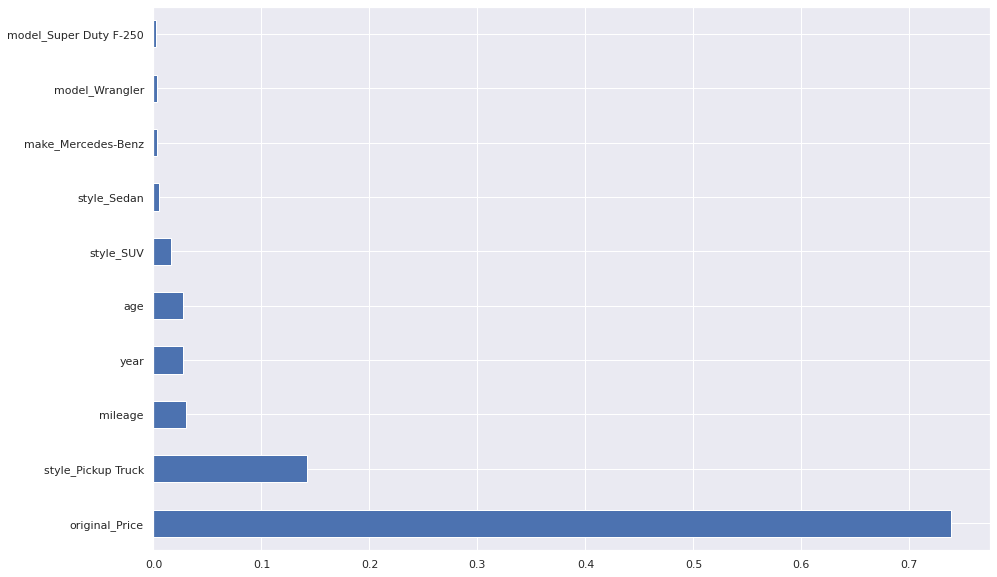

In [121]:
(pd.Series(et.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

# **Running KMeans**

Using KMeans, we can determine which of the models can give the best purchases. This is done by iterating through KMeans and finding the golden cluster. For each iteration, the elbow method is used to determine the number of clusters using SSE and the silouette scores.

In [155]:
def doKMeans(df, iterations=50):
  try:
    df.drop('cluster', axis=1, inplace=True)
  except:
    next
  X = df.iloc[:,1:]

  S={}
  SSE = {}

  rb = RobustScaler()
  X_rb = rb.fit_transform(X)

  for k in range(2, iterations):
      kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
      kmeans.fit(X_rb)
      SSE[k] = kmeans.inertia_
      S[k] = silhouette_score(X_rb, kmeans.labels_, random_state=10)


  fig, axs = plt.subplots(2)
  fig.tight_layout()
  axs[0].plot(list(SSE.keys()), list(SSE.values()))
  axs[0].set_xlabel("Number of Clusters")
  axs[0].set_ylabel("SSE Within Cluster")
  axs[0].set_title("Within Cluster SSE After K-Means Clustering")
  axs[0].set_xticks([i for i in range(2, iterations)])

  axs[1].plot(list(S.keys()), list(S.values()))
  axs[1].set_xlabel('Number of clusters')
  axs[1].set_ylabel("Silhouette Score")
  axs[1].set_xticks([i for i in range(2, iterations)])

def applyKMeans(df, clusters=2):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]

    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)  
    kmeans.fit(X_rb) 
    score = silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score))
    print("sse withing cluster: " + str(sse_within_cluster))

    plt.scatter(X_rb[:, 0], X_rb[:, 1], c= kmeans.labels_, s=15, cmap='viridis')
    centroids = kmeans.cluster_centers_
    plt.title('Clusters of Employees')
    plt.xlabel('PercentSalaryHike (US$)')
    plt.ylabel('Monthly Income (US$)')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker=",", c= "b", s=150)
        
    return df

In [174]:
cluster_col = ['make', 'model', 'price', 'age', 'mileage', 'depreciation', 'original_Price']
df_cluster = df_cor[cluster_col]
df_cluster['make'] = df_cluster['make'] + str(" ") +df_cluster['model']
df_cluster = df_cluster.drop(columns= 'model')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
df_cluster.head(10)

,make,price,age,mileage,depreciation,original_Price
0,Chevrolet Suburban,67994,0,8404,340685.188580,408679.188580
1,Cadillac CTS,37000,4,29342,185389.181067,222389.181067
2,Kia Forte,22395,2,17593,112210.559730,134605.559730
3,Ford F-150,20995,3,195205,105195.833959,126190.833959
4,Ford F-150,32988,3,47922,165286.981217,198274.981217
5,Ford Super Duty F-250,57899,2,24553,290104.005259,348003.005259
6,Nissan Altima,11785,6,119901,59048.959429,70833.959429
7,Nissan Altima,10995,6,92366,55090.649887,66085.649887
8,Toyota RAV4,21977,3,33633,110116.163035,132093.163035
9,Chevrolet Silverado 1500,25950,3,159889,130022.952667,155972.952667


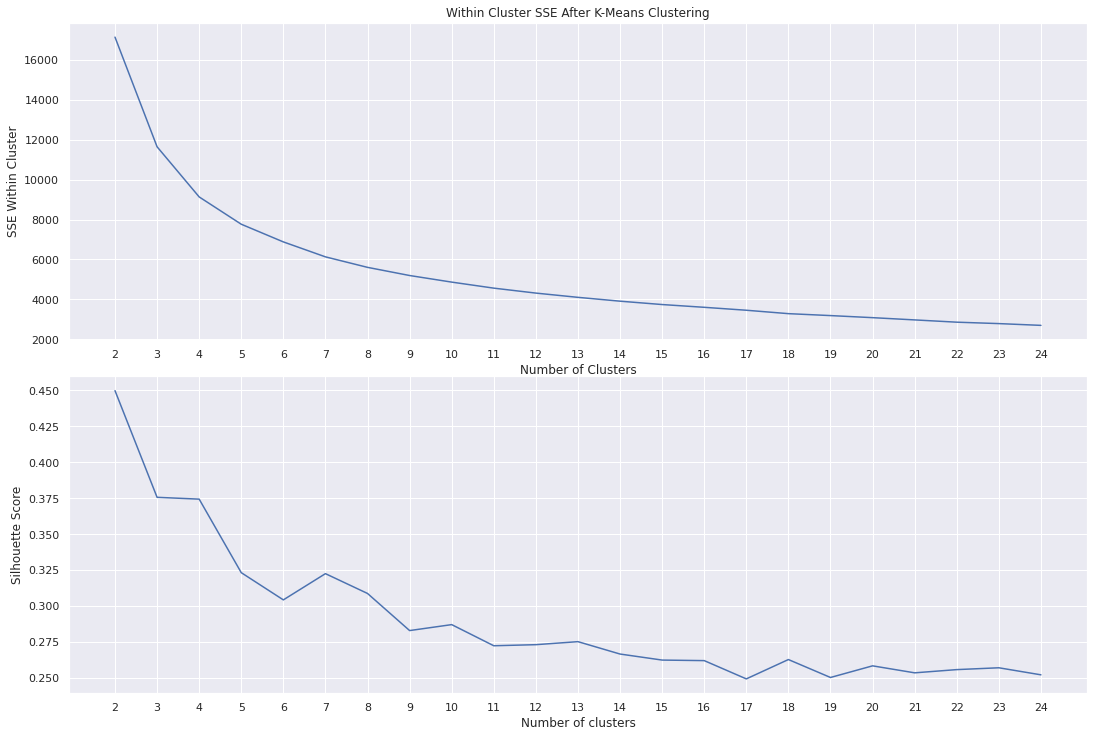

In [176]:
doKMeans(df_cluster, iterations=25)

We choose a cluster of 6 as using the elbow method.

clustering performance
-----------------------------------
silhouette score: 0.3041882004000695
sse withing cluster: 6878.785027043862


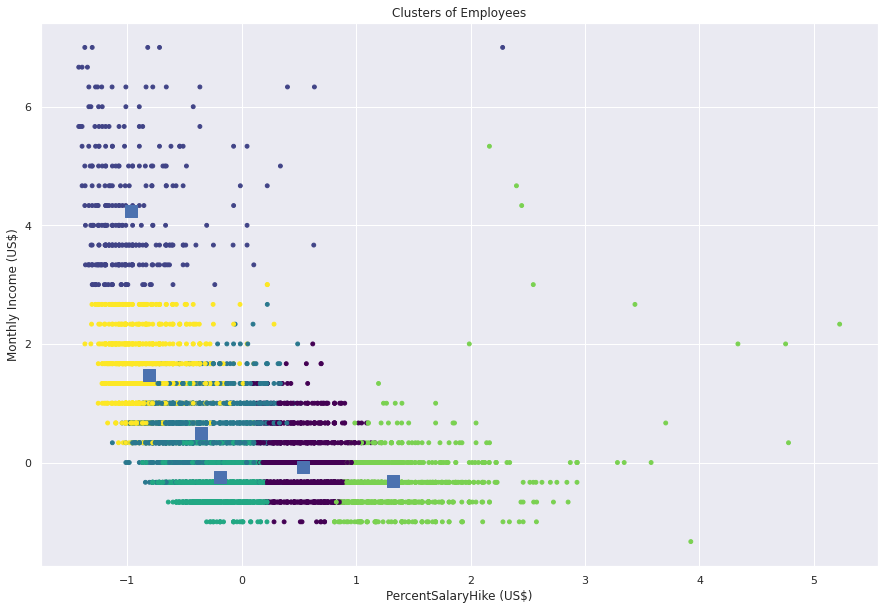

In [177]:
first_trial = applyKMeans(df_cluster, clusters=6)

In [178]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"make": "count", "price": "mean", "age": "mean", "mileage": "mean", "original_Price": "mean", "depreciation": "mean"})
    .sort_values('price')
    .reset_index()
)
cluster_perf_df

,cluster,make,price,age,mileage,original_Price,depreciation
0,1,299,9810.889632,15.709030,130532.317726,58968.532725,49157.643093
1,5,1125,12468.322667,7.438222,129259.295111,74941.082895,62472.760228
2,2,1822,20089.862788,4.489023,91289.935785,120750.490087,100660.627298
3,3,2689,22910.104500,2.277798,38710.171067,137701.604807,114791.500307
4,0,2869,35246.829557,2.797490,46040.284071,211851.717850,176604.888293
5,4,1096,48709.017336,2.052920,32333.541971,292766.445294,244057.427958


In [179]:
second_trial = first_trial.query("cluster == 4").reset_index(drop=True)

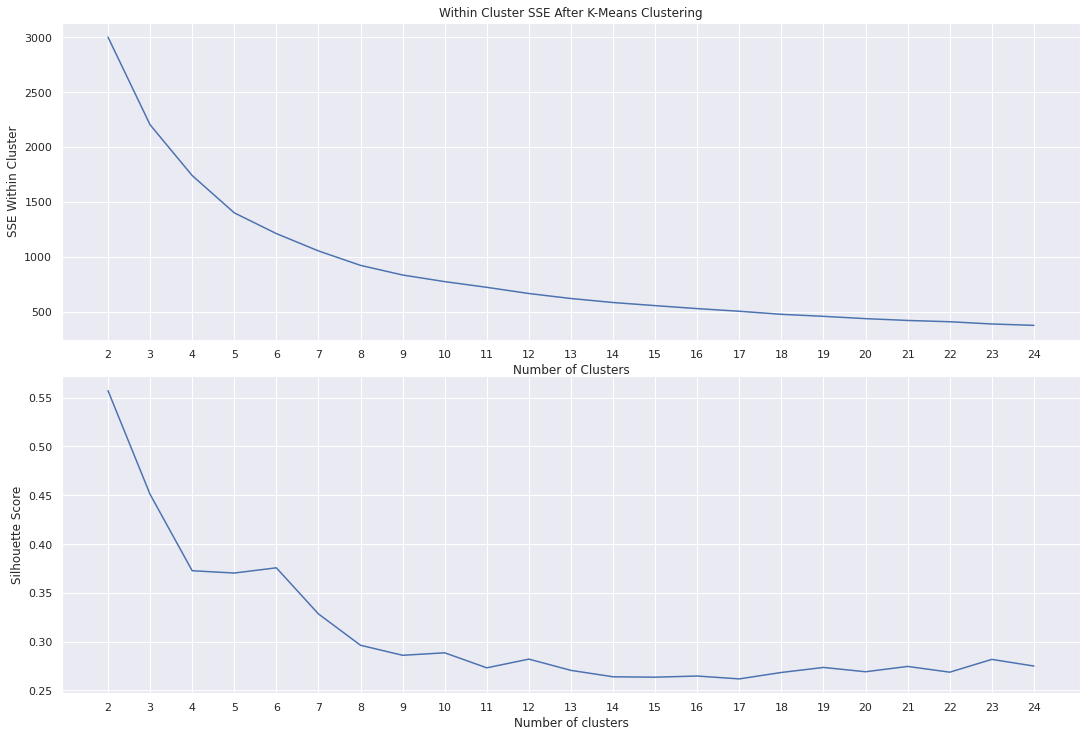

In [180]:
doKMeans(second_trial, iterations=25)

clustering performance
-----------------------------------
silhouette score: 0.3726397548408729
sse withing cluster: 1740.56062375083


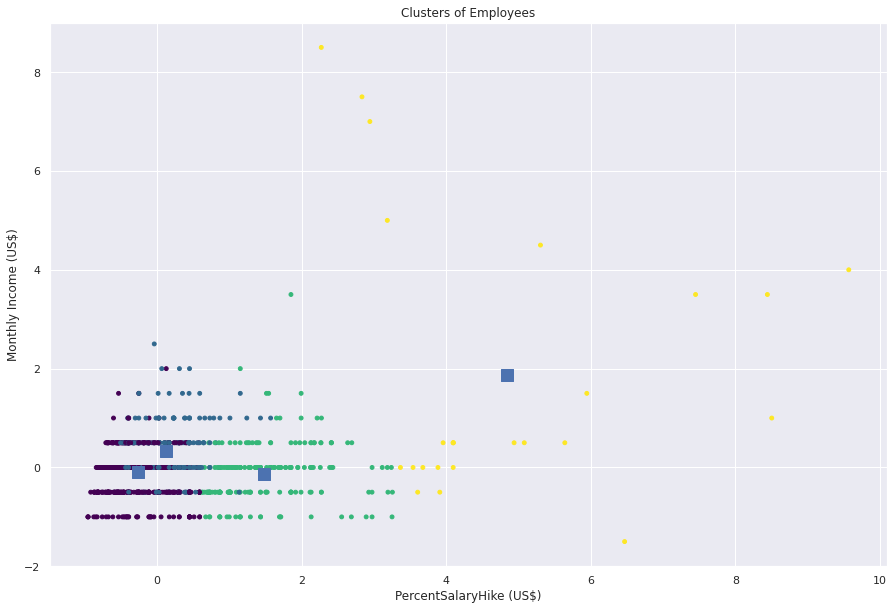

In [181]:
third_trial = applyKMeans(second_trial, clusters=4)

In [182]:
sub_df = (
    second_trial
    .groupby('cluster')
    .agg({"make": "count", "price": "mean", "age": "mean", "mileage": "mean", "original_Price": "mean", "depreciation": "mean"})
    .sort_values('price')
    .reset_index()
)
sub_df

,cluster,make,price,age,mileage,original_Price,depreciation
0,0,644,44961.013975,1.804348,23940.386646,270239.002105,225277.988129
1,1,215,47689.781395,2.665116,62232.572093,286640.308913,238950.527517
2,2,212,57289.084906,1.750000,27940.160377,344337.099358,287048.014452
3,3,25,81264.040000,5.760000,28665.440000,488439.008264,407174.968264


# **Modeling**

We can run multiple models to check the accuracy between the different Regressor models for predicting the car price.

In [131]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import utils

In [269]:
X = df.drop(['price', "make", "model", "city", "state", "style", "depreciation", "percent_Loss"], axis=1)
y = df['price']

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [271]:
names = ["Linear Regression", "MLPRegressor", "RandomForestRegressor", 
            "KNNRegressor", "XBoost Regressor"]

params = {'n_estimators': 500,
            'max_depth': 4,
            'min_samples_split': 5,
            'learning_rate': 0.01,
            'loss': 'ls'}

regressors = [
      LinearRegression(),
      MLPRegressor(random_state=1, max_iter=500),
      RandomForestRegressor(max_depth=2, random_state=0),
      KNeighborsRegressor(n_neighbors=2),
      GradientBoostingRegressor(**params)]

In [272]:
max_score = 0.0
max_class = ''
# iterate over regressors
for name, clf in zip(names, regressors):
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    pred = clf.predict(X_train)
    r2 = r2_score(y_train, pred)
    print('R2 SCORE = %.2f,' %(r2))
    print('regressors = %s, Score (test, accuracy) = %.2f,' %(name, score))
    
    if score > max_score:
        reg_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> regressors = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))


R2 SCORE = 1.00,
regressors = Linear Regression, Score (test, accuracy) = 100.00,
R2 SCORE = 1.00,
regressors = MLPRegressor, Score (test, accuracy) = 100.00,
R2 SCORE = 0.89,
regressors = RandomForestRegressor, Score (test, accuracy) = 89.53,
R2 SCORE = 1.00,
regressors = KNNRegressor, Score (test, accuracy) = 99.98,


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


R2 SCORE = 1.00,
regressors = XBoost Regressor, Score (test, accuracy) = 99.99,
--------------------------------------------------------------------------------
Best --> regressors = Linear Regression, Score (test, accuracy) = 100.00


In [273]:
rf = RandomForestRegressor()

In [274]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [275]:
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [276]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [277]:
rf_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [278]:
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [279]:
pred = rf_model.predict(X_test)
print(metrics.r2_score(y_test, pred))

0.9998074620436979


In [292]:
print(X_test)

      year  mileage  accidents  owners  age  original_Price
1284  2020    71947          0       1    1   270413.223140
5935  2016    52027          0       2    5   185881.292261
8785  2019    49869          0       1    2    78076.634110
3323  2017   153580          0       1    4    92309.541698
323   2020    44983          0       2    1   123215.627348
...    ...      ...        ...     ...  ...             ...
1294  2018    22901          0       1    3   264462.809917
1478  2016   108984          0       1    5    69217.129977
6923  2010   232759          1       3   11    23795.642374
7579  2019    13068          0       1    2   191735.537190
1516  1999    91210          0       5   22    78118.707739

[2475 rows x 6 columns]


In [280]:
print(type(rf_model))

<class 'sklearn.model_selection._search.RandomizedSearchCV'>


In [281]:
rf_model.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 700}

In [282]:
rf_model.best_score_

-264763.71129037946

In [283]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 16.625078411734602
MSE: 25456.499013210145
RMSE: 159.55092921449923


The predicted prices for the cars are pretty accurate compared to actual prices, so we know we have an accurate model.

In [284]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
df1 = results.head(40)
df1.head(30)

,Actual,Predicted
1284,44990,44989.595693
5935,30926,30911.907986
8785,12990,12988.130234
3323,15358,15346.629545
323,20500,20498.896645
7980,37000,36999.739243
4491,45988,45990.972283
2295,42772,42793.077606
8977,22329,22332.800542
1499,27988,27988.463763


# **Pickling the model**

Pickle the model to use to generate the front end flask API heroku app

In [298]:
import pickle
import joblib

picklePath = '/content' + '/gdrive' + '/My Drive' + '/Colab Notebooks' + '/Data Mining' + '/Final Project/' + 'random_forest_regression_model.pkl'
with open(picklePath,'wb') as f:
    pickle.dump(rf_model, f)
print('pickle file is created:', picklePath)

pickle file is created: /content/gdrive/My Drive/Colab Notebooks/Data Mining/Final Project/random_forest_regression_model.pkl


In [299]:
model = joblib.load(picklePath)
model.predict(X_test)

array([44989.59569261, 30911.9079856 , 12988.1302338 , ...,
        3973.45386215, 31896.47682215, 12998.9904253 ])

In [300]:
model.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 700}

In [301]:
model.best_score_

-264763.71129037946

In [302]:
prediction = model.predict([[2019, 12345, 0, 2, 2, 270413]])
output=round(prediction[0],2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


In [303]:
if output < 0:
  print("Car Cannot be sold")
else:
  print("Car's predicted value is ${}".format(output))

Car's predicted value is $44989.5
